**Graph AUTOENCODER con ADVERSARIAL**
---
01. ARGA
02. ARVGA
---
Paper:
* [Adversarially Regularized Graph Autoencoder for Graph Embedding](https://www.ijcai.org/Proceedings/2018/0362.pdf)  

Code:
 * [ARGA & ARVGA](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/autoencoder.html)
 * [Example on clustering](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/argva_node_clustering.py)

---
Jonnatan Arias Garcia

jonnatan.arias@utp.edu.co
jariasg@uniquindio.edu.co

# Utils & Imports

In [2]:
import os
import torch
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

2.2.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import os.path as osp
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import (v_measure_score, homogeneity_score, completeness_score)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models.autoencoder import ARGVA
from torch_geometric.utils import train_test_split_edges

# Dataset

In [4]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset.get(0)

Processing...
Done!


In [5]:
num_nodes = data.x.shape[0]

train - validation - test

In [6]:
data.train_mask = data.val_mask = data.test_mask = None
data = train_test_split_edges(data)
data

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[2708, 1433], y=[2708], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])

# Model

In [7]:
class VEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

Definiendo el discriminador

In [8]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Discriminator, self).__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

## Funciones para Train - Test

In [9]:
def train():
    model.train()
    encoder_optimizer.zero_grad()

    z = model.encode(data.x, data.train_pos_edge_index)

    for i in range(5):
        idx = range(num_nodes)
        discriminator.train()
        discriminator_optimizer.zero_grad()
        discriminator_loss = model.discriminator_loss(z[idx]) # Comment
        discriminator_loss.backward(retain_graph=True)
        discriminator_optimizer.step()

    loss = 0
    loss = loss + model.reg_loss(z)  # Comment

    loss = loss + model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()

    encoder_optimizer.step()

    return loss

In [10]:
@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)

    # Cluster embedded values using k-means.
    kmeans_input = z.cpu().numpy()
    kmeans = KMeans(n_clusters=7, random_state=0).fit(kmeans_input)
    pred = kmeans.predict(kmeans_input)

    labels = data.y.cpu().numpy()
    completeness = completeness_score(labels, pred)
    hm = homogeneity_score(labels, pred)
    nmi = v_measure_score(labels, pred)

    auc, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

    return auc, ap, completeness, hm, nmi

# Inicializando el modelo

In [11]:
latent_size = 32
encoder = VEncoder(data.num_features, out_channels=latent_size)

discriminator = Discriminator(in_channels=latent_size, hidden_channels=64,
                              out_channels=1) # Comment

In [12]:
model = ARGVA(encoder, discriminator)

device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
model, data = model.to(device), data.to(device)

In [13]:
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.005)

#Train

In [14]:
for epoch in range(1, 201):
    loss = train()
    auc, ap, completeness, hm, nmi = test()
    print((f'Epoch: {epoch:03d}, Loss: {loss:.3f}, AUC: {auc:.3f}, '
           f'AP: {ap:.3f}, Completeness: {completeness:.3f}, '
           f'Homogeneity: {hm:.3f}, NMI: {nmi:.3f}'))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 001, Loss: 5.455, AUC: 0.717, AP: 0.730, Completeness: 0.137, Homogeneity: 0.134, NMI: 0.136


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 002, Loss: 4.960, AUC: 0.694, AP: 0.719, Completeness: 0.123, Homogeneity: 0.115, NMI: 0.119


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 003, Loss: 4.529, AUC: 0.687, AP: 0.714, Completeness: 0.124, Homogeneity: 0.116, NMI: 0.120


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 004, Loss: 4.090, AUC: 0.686, AP: 0.714, Completeness: 0.129, Homogeneity: 0.121, NMI: 0.125


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 005, Loss: 3.755, AUC: 0.691, AP: 0.720, Completeness: 0.152, Homogeneity: 0.143, NMI: 0.148


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 006, Loss: 3.371, AUC: 0.705, AP: 0.734, Completeness: 0.175, Homogeneity: 0.168, NMI: 0.172


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 007, Loss: 3.002, AUC: 0.730, AP: 0.755, Completeness: 0.199, Homogeneity: 0.190, NMI: 0.194


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 008, Loss: 2.710, AUC: 0.740, AP: 0.761, Completeness: 0.214, Homogeneity: 0.203, NMI: 0.208


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 009, Loss: 2.530, AUC: 0.728, AP: 0.748, Completeness: 0.207, Homogeneity: 0.203, NMI: 0.205


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 010, Loss: 2.419, AUC: 0.717, AP: 0.742, Completeness: 0.203, Homogeneity: 0.198, NMI: 0.200


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 011, Loss: 2.367, AUC: 0.714, AP: 0.741, Completeness: 0.218, Homogeneity: 0.211, NMI: 0.215


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 012, Loss: 2.339, AUC: 0.718, AP: 0.748, Completeness: 0.239, Homogeneity: 0.233, NMI: 0.236


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 013, Loss: 2.314, AUC: 0.730, AP: 0.760, Completeness: 0.270, Homogeneity: 0.259, NMI: 0.264


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 014, Loss: 2.314, AUC: 0.750, AP: 0.776, Completeness: 0.262, Homogeneity: 0.256, NMI: 0.259


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 015, Loss: 2.321, AUC: 0.766, AP: 0.789, Completeness: 0.277, Homogeneity: 0.274, NMI: 0.276


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 016, Loss: 2.360, AUC: 0.767, AP: 0.789, Completeness: 0.300, Homogeneity: 0.290, NMI: 0.295


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 017, Loss: 2.421, AUC: 0.757, AP: 0.781, Completeness: 0.298, Homogeneity: 0.282, NMI: 0.290


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 018, Loss: 2.546, AUC: 0.754, AP: 0.779, Completeness: 0.302, Homogeneity: 0.284, NMI: 0.293


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 019, Loss: 2.683, AUC: 0.762, AP: 0.787, Completeness: 0.287, Homogeneity: 0.278, NMI: 0.282


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 020, Loss: 2.750, AUC: 0.775, AP: 0.800, Completeness: 0.319, Homogeneity: 0.309, NMI: 0.314


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 021, Loss: 2.763, AUC: 0.789, AP: 0.812, Completeness: 0.333, Homogeneity: 0.325, NMI: 0.329


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 022, Loss: 2.788, AUC: 0.795, AP: 0.817, Completeness: 0.341, Homogeneity: 0.340, NMI: 0.341


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 023, Loss: 2.893, AUC: 0.797, AP: 0.817, Completeness: 0.347, Homogeneity: 0.345, NMI: 0.346


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 024, Loss: 3.028, AUC: 0.800, AP: 0.819, Completeness: 0.354, Homogeneity: 0.354, NMI: 0.354


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 025, Loss: 3.204, AUC: 0.798, AP: 0.817, Completeness: 0.382, Homogeneity: 0.386, NMI: 0.384


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 026, Loss: 3.378, AUC: 0.793, AP: 0.812, Completeness: 0.383, Homogeneity: 0.391, NMI: 0.387


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 027, Loss: 3.522, AUC: 0.793, AP: 0.808, Completeness: 0.383, Homogeneity: 0.390, NMI: 0.386


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 028, Loss: 3.636, AUC: 0.798, AP: 0.810, Completeness: 0.385, Homogeneity: 0.394, NMI: 0.389


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 029, Loss: 3.677, AUC: 0.810, AP: 0.817, Completeness: 0.388, Homogeneity: 0.398, NMI: 0.393


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 030, Loss: 3.662, AUC: 0.826, AP: 0.830, Completeness: 0.398, Homogeneity: 0.408, NMI: 0.403


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 031, Loss: 3.634, AUC: 0.842, AP: 0.844, Completeness: 0.400, Homogeneity: 0.408, NMI: 0.404


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 032, Loss: 3.646, AUC: 0.850, AP: 0.852, Completeness: 0.391, Homogeneity: 0.384, NMI: 0.387


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 033, Loss: 3.701, AUC: 0.845, AP: 0.848, Completeness: 0.365, Homogeneity: 0.356, NMI: 0.361


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 034, Loss: 3.830, AUC: 0.829, AP: 0.834, Completeness: 0.368, Homogeneity: 0.345, NMI: 0.356


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 035, Loss: 3.982, AUC: 0.811, AP: 0.819, Completeness: 0.341, Homogeneity: 0.328, NMI: 0.335


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 036, Loss: 4.157, AUC: 0.798, AP: 0.809, Completeness: 0.324, Homogeneity: 0.301, NMI: 0.312


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 037, Loss: 4.333, AUC: 0.792, AP: 0.805, Completeness: 0.311, Homogeneity: 0.290, NMI: 0.300


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 038, Loss: 4.478, AUC: 0.793, AP: 0.807, Completeness: 0.306, Homogeneity: 0.286, NMI: 0.296


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 039, Loss: 4.534, AUC: 0.800, AP: 0.812, Completeness: 0.319, Homogeneity: 0.293, NMI: 0.305


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 040, Loss: 4.502, AUC: 0.810, AP: 0.820, Completeness: 0.323, Homogeneity: 0.296, NMI: 0.309


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 041, Loss: 4.462, AUC: 0.820, AP: 0.826, Completeness: 0.335, Homogeneity: 0.307, NMI: 0.321


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 042, Loss: 4.551, AUC: 0.830, AP: 0.833, Completeness: 0.346, Homogeneity: 0.317, NMI: 0.331


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 043, Loss: 4.477, AUC: 0.836, AP: 0.837, Completeness: 0.347, Homogeneity: 0.319, NMI: 0.332


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 044, Loss: 4.477, AUC: 0.838, AP: 0.839, Completeness: 0.354, Homogeneity: 0.323, NMI: 0.338


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 045, Loss: 4.451, AUC: 0.837, AP: 0.840, Completeness: 0.359, Homogeneity: 0.328, NMI: 0.343


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 046, Loss: 4.459, AUC: 0.834, AP: 0.838, Completeness: 0.364, Homogeneity: 0.333, NMI: 0.347


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 047, Loss: 4.313, AUC: 0.832, AP: 0.837, Completeness: 0.366, Homogeneity: 0.336, NMI: 0.350


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 048, Loss: 4.443, AUC: 0.830, AP: 0.835, Completeness: 0.374, Homogeneity: 0.343, NMI: 0.358


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 049, Loss: 4.355, AUC: 0.829, AP: 0.834, Completeness: 0.378, Homogeneity: 0.346, NMI: 0.361


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 050, Loss: 4.320, AUC: 0.829, AP: 0.834, Completeness: 0.378, Homogeneity: 0.346, NMI: 0.361


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 051, Loss: 4.231, AUC: 0.829, AP: 0.833, Completeness: 0.377, Homogeneity: 0.344, NMI: 0.360


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 052, Loss: 4.181, AUC: 0.829, AP: 0.832, Completeness: 0.359, Homogeneity: 0.351, NMI: 0.355


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 053, Loss: 4.146, AUC: 0.831, AP: 0.832, Completeness: 0.360, Homogeneity: 0.353, NMI: 0.357


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 054, Loss: 4.104, AUC: 0.831, AP: 0.831, Completeness: 0.369, Homogeneity: 0.361, NMI: 0.365


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 055, Loss: 4.034, AUC: 0.831, AP: 0.831, Completeness: 0.370, Homogeneity: 0.363, NMI: 0.367


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 056, Loss: 3.993, AUC: 0.831, AP: 0.830, Completeness: 0.366, Homogeneity: 0.361, NMI: 0.363


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 057, Loss: 3.990, AUC: 0.831, AP: 0.829, Completeness: 0.371, Homogeneity: 0.366, NMI: 0.369


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 058, Loss: 4.001, AUC: 0.830, AP: 0.828, Completeness: 0.375, Homogeneity: 0.370, NMI: 0.372


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 059, Loss: 3.994, AUC: 0.829, AP: 0.827, Completeness: 0.372, Homogeneity: 0.369, NMI: 0.370


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 060, Loss: 4.016, AUC: 0.828, AP: 0.827, Completeness: 0.393, Homogeneity: 0.382, NMI: 0.387


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 061, Loss: 4.007, AUC: 0.827, AP: 0.827, Completeness: 0.392, Homogeneity: 0.383, NMI: 0.387


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 062, Loss: 4.042, AUC: 0.826, AP: 0.826, Completeness: 0.412, Homogeneity: 0.382, NMI: 0.396


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 063, Loss: 4.092, AUC: 0.825, AP: 0.826, Completeness: 0.415, Homogeneity: 0.388, NMI: 0.401


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 064, Loss: 4.120, AUC: 0.825, AP: 0.826, Completeness: 0.412, Homogeneity: 0.386, NMI: 0.398


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 065, Loss: 4.142, AUC: 0.824, AP: 0.826, Completeness: 0.413, Homogeneity: 0.386, NMI: 0.399


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 066, Loss: 4.116, AUC: 0.824, AP: 0.825, Completeness: 0.417, Homogeneity: 0.391, NMI: 0.403


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 067, Loss: 4.208, AUC: 0.823, AP: 0.825, Completeness: 0.416, Homogeneity: 0.391, NMI: 0.403


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 068, Loss: 4.172, AUC: 0.823, AP: 0.825, Completeness: 0.420, Homogeneity: 0.393, NMI: 0.406


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 069, Loss: 4.187, AUC: 0.823, AP: 0.825, Completeness: 0.426, Homogeneity: 0.399, NMI: 0.412


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 070, Loss: 4.254, AUC: 0.824, AP: 0.826, Completeness: 0.423, Homogeneity: 0.402, NMI: 0.412


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 071, Loss: 4.281, AUC: 0.825, AP: 0.827, Completeness: 0.424, Homogeneity: 0.403, NMI: 0.414


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 072, Loss: 4.230, AUC: 0.826, AP: 0.828, Completeness: 0.429, Homogeneity: 0.406, NMI: 0.417


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 073, Loss: 4.314, AUC: 0.827, AP: 0.830, Completeness: 0.428, Homogeneity: 0.406, NMI: 0.417


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 074, Loss: 4.317, AUC: 0.828, AP: 0.831, Completeness: 0.430, Homogeneity: 0.408, NMI: 0.419


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 075, Loss: 4.286, AUC: 0.830, AP: 0.832, Completeness: 0.431, Homogeneity: 0.410, NMI: 0.420


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 076, Loss: 4.233, AUC: 0.832, AP: 0.834, Completeness: 0.434, Homogeneity: 0.414, NMI: 0.424


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 077, Loss: 4.228, AUC: 0.834, AP: 0.836, Completeness: 0.436, Homogeneity: 0.417, NMI: 0.426


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 078, Loss: 4.136, AUC: 0.837, AP: 0.838, Completeness: 0.439, Homogeneity: 0.420, NMI: 0.429


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 079, Loss: 4.198, AUC: 0.840, AP: 0.841, Completeness: 0.441, Homogeneity: 0.423, NMI: 0.432


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 080, Loss: 4.194, AUC: 0.843, AP: 0.844, Completeness: 0.443, Homogeneity: 0.426, NMI: 0.434


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 081, Loss: 4.144, AUC: 0.846, AP: 0.847, Completeness: 0.446, Homogeneity: 0.434, NMI: 0.440


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 082, Loss: 4.105, AUC: 0.849, AP: 0.850, Completeness: 0.451, Homogeneity: 0.441, NMI: 0.446


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 083, Loss: 4.086, AUC: 0.851, AP: 0.853, Completeness: 0.452, Homogeneity: 0.444, NMI: 0.448


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 084, Loss: 4.080, AUC: 0.854, AP: 0.856, Completeness: 0.453, Homogeneity: 0.445, NMI: 0.449


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 085, Loss: 4.114, AUC: 0.856, AP: 0.859, Completeness: 0.453, Homogeneity: 0.446, NMI: 0.449


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 086, Loss: 4.145, AUC: 0.859, AP: 0.861, Completeness: 0.449, Homogeneity: 0.443, NMI: 0.446


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 087, Loss: 4.042, AUC: 0.862, AP: 0.863, Completeness: 0.450, Homogeneity: 0.445, NMI: 0.448


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 088, Loss: 4.038, AUC: 0.864, AP: 0.865, Completeness: 0.451, Homogeneity: 0.446, NMI: 0.449


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 089, Loss: 4.055, AUC: 0.867, AP: 0.867, Completeness: 0.452, Homogeneity: 0.448, NMI: 0.450


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 090, Loss: 4.048, AUC: 0.870, AP: 0.870, Completeness: 0.453, Homogeneity: 0.449, NMI: 0.451


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 091, Loss: 4.151, AUC: 0.873, AP: 0.873, Completeness: 0.450, Homogeneity: 0.446, NMI: 0.448


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 092, Loss: 4.161, AUC: 0.876, AP: 0.875, Completeness: 0.447, Homogeneity: 0.443, NMI: 0.445


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 093, Loss: 4.046, AUC: 0.879, AP: 0.877, Completeness: 0.446, Homogeneity: 0.444, NMI: 0.445


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 094, Loss: 4.092, AUC: 0.881, AP: 0.878, Completeness: 0.443, Homogeneity: 0.442, NMI: 0.443


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 095, Loss: 4.184, AUC: 0.883, AP: 0.879, Completeness: 0.446, Homogeneity: 0.445, NMI: 0.445


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 096, Loss: 4.160, AUC: 0.884, AP: 0.880, Completeness: 0.447, Homogeneity: 0.448, NMI: 0.447


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 097, Loss: 4.126, AUC: 0.885, AP: 0.881, Completeness: 0.448, Homogeneity: 0.449, NMI: 0.448


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 098, Loss: 4.152, AUC: 0.887, AP: 0.882, Completeness: 0.449, Homogeneity: 0.450, NMI: 0.450


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 099, Loss: 4.045, AUC: 0.888, AP: 0.882, Completeness: 0.449, Homogeneity: 0.450, NMI: 0.449


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 100, Loss: 4.078, AUC: 0.889, AP: 0.883, Completeness: 0.455, Homogeneity: 0.456, NMI: 0.455


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 101, Loss: 3.979, AUC: 0.890, AP: 0.884, Completeness: 0.456, Homogeneity: 0.457, NMI: 0.457


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 102, Loss: 3.936, AUC: 0.891, AP: 0.885, Completeness: 0.456, Homogeneity: 0.458, NMI: 0.457


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 103, Loss: 4.083, AUC: 0.892, AP: 0.885, Completeness: 0.459, Homogeneity: 0.460, NMI: 0.460


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 104, Loss: 4.022, AUC: 0.893, AP: 0.886, Completeness: 0.461, Homogeneity: 0.463, NMI: 0.462


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 105, Loss: 3.952, AUC: 0.893, AP: 0.887, Completeness: 0.459, Homogeneity: 0.462, NMI: 0.461


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 106, Loss: 3.899, AUC: 0.894, AP: 0.888, Completeness: 0.460, Homogeneity: 0.462, NMI: 0.461


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 107, Loss: 3.889, AUC: 0.895, AP: 0.889, Completeness: 0.457, Homogeneity: 0.460, NMI: 0.458


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 108, Loss: 3.794, AUC: 0.896, AP: 0.890, Completeness: 0.457, Homogeneity: 0.460, NMI: 0.458


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 109, Loss: 3.866, AUC: 0.896, AP: 0.890, Completeness: 0.461, Homogeneity: 0.464, NMI: 0.462


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 110, Loss: 3.855, AUC: 0.896, AP: 0.891, Completeness: 0.459, Homogeneity: 0.463, NMI: 0.461


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 111, Loss: 3.801, AUC: 0.896, AP: 0.891, Completeness: 0.456, Homogeneity: 0.461, NMI: 0.458


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 112, Loss: 3.800, AUC: 0.897, AP: 0.891, Completeness: 0.455, Homogeneity: 0.461, NMI: 0.458


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 113, Loss: 3.742, AUC: 0.897, AP: 0.892, Completeness: 0.452, Homogeneity: 0.459, NMI: 0.455


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 114, Loss: 3.861, AUC: 0.898, AP: 0.894, Completeness: 0.452, Homogeneity: 0.458, NMI: 0.455


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 115, Loss: 3.849, AUC: 0.899, AP: 0.895, Completeness: 0.453, Homogeneity: 0.459, NMI: 0.456


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 116, Loss: 3.783, AUC: 0.901, AP: 0.898, Completeness: 0.453, Homogeneity: 0.459, NMI: 0.456


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 117, Loss: 3.852, AUC: 0.902, AP: 0.899, Completeness: 0.455, Homogeneity: 0.461, NMI: 0.458


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 118, Loss: 3.878, AUC: 0.903, AP: 0.901, Completeness: 0.456, Homogeneity: 0.462, NMI: 0.459


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 119, Loss: 3.789, AUC: 0.905, AP: 0.902, Completeness: 0.450, Homogeneity: 0.455, NMI: 0.452


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 120, Loss: 3.878, AUC: 0.905, AP: 0.902, Completeness: 0.445, Homogeneity: 0.450, NMI: 0.447


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 121, Loss: 3.921, AUC: 0.905, AP: 0.902, Completeness: 0.448, Homogeneity: 0.452, NMI: 0.450


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 122, Loss: 3.899, AUC: 0.906, AP: 0.902, Completeness: 0.443, Homogeneity: 0.446, NMI: 0.445


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 123, Loss: 3.827, AUC: 0.906, AP: 0.902, Completeness: 0.445, Homogeneity: 0.447, NMI: 0.446


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 124, Loss: 3.921, AUC: 0.907, AP: 0.902, Completeness: 0.445, Homogeneity: 0.447, NMI: 0.446


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 125, Loss: 3.871, AUC: 0.908, AP: 0.903, Completeness: 0.445, Homogeneity: 0.448, NMI: 0.446


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 126, Loss: 3.970, AUC: 0.909, AP: 0.904, Completeness: 0.445, Homogeneity: 0.447, NMI: 0.446


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 127, Loss: 3.909, AUC: 0.910, AP: 0.905, Completeness: 0.444, Homogeneity: 0.446, NMI: 0.445


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 128, Loss: 3.885, AUC: 0.911, AP: 0.907, Completeness: 0.444, Homogeneity: 0.446, NMI: 0.445


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 129, Loss: 3.881, AUC: 0.912, AP: 0.908, Completeness: 0.443, Homogeneity: 0.445, NMI: 0.444


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 130, Loss: 3.889, AUC: 0.914, AP: 0.910, Completeness: 0.445, Homogeneity: 0.447, NMI: 0.446


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 131, Loss: 3.853, AUC: 0.915, AP: 0.912, Completeness: 0.444, Homogeneity: 0.444, NMI: 0.444


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 132, Loss: 3.936, AUC: 0.916, AP: 0.913, Completeness: 0.511, Homogeneity: 0.504, NMI: 0.507


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 133, Loss: 3.897, AUC: 0.916, AP: 0.914, Completeness: 0.510, Homogeneity: 0.504, NMI: 0.507


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 134, Loss: 3.878, AUC: 0.916, AP: 0.914, Completeness: 0.446, Homogeneity: 0.445, NMI: 0.445


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 135, Loss: 3.826, AUC: 0.916, AP: 0.914, Completeness: 0.510, Homogeneity: 0.500, NMI: 0.505


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 136, Loss: 3.737, AUC: 0.917, AP: 0.914, Completeness: 0.507, Homogeneity: 0.496, NMI: 0.502


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 137, Loss: 3.904, AUC: 0.916, AP: 0.914, Completeness: 0.500, Homogeneity: 0.488, NMI: 0.494


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 138, Loss: 3.820, AUC: 0.917, AP: 0.915, Completeness: 0.496, Homogeneity: 0.485, NMI: 0.491


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 139, Loss: 3.917, AUC: 0.917, AP: 0.915, Completeness: 0.494, Homogeneity: 0.481, NMI: 0.487


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 140, Loss: 3.821, AUC: 0.918, AP: 0.916, Completeness: 0.492, Homogeneity: 0.479, NMI: 0.486


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 141, Loss: 3.797, AUC: 0.918, AP: 0.916, Completeness: 0.478, Homogeneity: 0.489, NMI: 0.483


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 142, Loss: 3.797, AUC: 0.919, AP: 0.917, Completeness: 0.480, Homogeneity: 0.491, NMI: 0.485


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 143, Loss: 3.769, AUC: 0.919, AP: 0.918, Completeness: 0.478, Homogeneity: 0.489, NMI: 0.484


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 144, Loss: 3.873, AUC: 0.920, AP: 0.918, Completeness: 0.487, Homogeneity: 0.501, NMI: 0.494


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 145, Loss: 3.756, AUC: 0.920, AP: 0.918, Completeness: 0.492, Homogeneity: 0.505, NMI: 0.498


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 146, Loss: 3.764, AUC: 0.920, AP: 0.918, Completeness: 0.490, Homogeneity: 0.504, NMI: 0.497


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 147, Loss: 3.738, AUC: 0.919, AP: 0.918, Completeness: 0.493, Homogeneity: 0.505, NMI: 0.499


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 148, Loss: 3.688, AUC: 0.918, AP: 0.917, Completeness: 0.496, Homogeneity: 0.508, NMI: 0.502


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 149, Loss: 3.733, AUC: 0.918, AP: 0.916, Completeness: 0.499, Homogeneity: 0.512, NMI: 0.505


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 150, Loss: 3.758, AUC: 0.918, AP: 0.916, Completeness: 0.498, Homogeneity: 0.511, NMI: 0.505


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 151, Loss: 3.646, AUC: 0.917, AP: 0.916, Completeness: 0.497, Homogeneity: 0.509, NMI: 0.503


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 152, Loss: 3.709, AUC: 0.918, AP: 0.916, Completeness: 0.501, Homogeneity: 0.512, NMI: 0.506


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 153, Loss: 3.751, AUC: 0.917, AP: 0.917, Completeness: 0.502, Homogeneity: 0.513, NMI: 0.507


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 154, Loss: 3.680, AUC: 0.917, AP: 0.918, Completeness: 0.500, Homogeneity: 0.511, NMI: 0.506


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 155, Loss: 3.765, AUC: 0.917, AP: 0.918, Completeness: 0.520, Homogeneity: 0.525, NMI: 0.522


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 156, Loss: 3.703, AUC: 0.916, AP: 0.918, Completeness: 0.506, Homogeneity: 0.516, NMI: 0.511


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 157, Loss: 3.744, AUC: 0.916, AP: 0.917, Completeness: 0.526, Homogeneity: 0.528, NMI: 0.527


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 158, Loss: 3.681, AUC: 0.916, AP: 0.917, Completeness: 0.523, Homogeneity: 0.526, NMI: 0.525


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 159, Loss: 3.713, AUC: 0.916, AP: 0.917, Completeness: 0.519, Homogeneity: 0.523, NMI: 0.521


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 160, Loss: 3.660, AUC: 0.916, AP: 0.917, Completeness: 0.509, Homogeneity: 0.517, NMI: 0.513


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 161, Loss: 3.680, AUC: 0.915, AP: 0.916, Completeness: 0.506, Homogeneity: 0.517, NMI: 0.512


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 162, Loss: 3.589, AUC: 0.915, AP: 0.916, Completeness: 0.485, Homogeneity: 0.497, NMI: 0.491


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 163, Loss: 3.637, AUC: 0.915, AP: 0.917, Completeness: 0.489, Homogeneity: 0.501, NMI: 0.495


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 164, Loss: 3.596, AUC: 0.916, AP: 0.917, Completeness: 0.470, Homogeneity: 0.490, NMI: 0.480


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 165, Loss: 3.582, AUC: 0.916, AP: 0.918, Completeness: 0.462, Homogeneity: 0.482, NMI: 0.472


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 166, Loss: 3.604, AUC: 0.917, AP: 0.918, Completeness: 0.458, Homogeneity: 0.478, NMI: 0.468


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 167, Loss: 3.621, AUC: 0.917, AP: 0.919, Completeness: 0.458, Homogeneity: 0.478, NMI: 0.468


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 168, Loss: 3.602, AUC: 0.918, AP: 0.920, Completeness: 0.459, Homogeneity: 0.479, NMI: 0.469


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 169, Loss: 3.616, AUC: 0.918, AP: 0.921, Completeness: 0.453, Homogeneity: 0.473, NMI: 0.463


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 170, Loss: 3.563, AUC: 0.919, AP: 0.922, Completeness: 0.451, Homogeneity: 0.471, NMI: 0.461


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 171, Loss: 3.634, AUC: 0.920, AP: 0.923, Completeness: 0.450, Homogeneity: 0.469, NMI: 0.459


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 172, Loss: 3.613, AUC: 0.921, AP: 0.923, Completeness: 0.448, Homogeneity: 0.466, NMI: 0.457


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 173, Loss: 3.579, AUC: 0.921, AP: 0.923, Completeness: 0.449, Homogeneity: 0.467, NMI: 0.458


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 174, Loss: 3.596, AUC: 0.921, AP: 0.923, Completeness: 0.432, Homogeneity: 0.452, NMI: 0.442


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 175, Loss: 3.646, AUC: 0.921, AP: 0.924, Completeness: 0.446, Homogeneity: 0.465, NMI: 0.455


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 176, Loss: 3.596, AUC: 0.922, AP: 0.924, Completeness: 0.437, Homogeneity: 0.456, NMI: 0.446


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 177, Loss: 3.547, AUC: 0.922, AP: 0.925, Completeness: 0.419, Homogeneity: 0.436, NMI: 0.427


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 178, Loss: 3.580, AUC: 0.922, AP: 0.925, Completeness: 0.432, Homogeneity: 0.454, NMI: 0.443


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 179, Loss: 3.615, AUC: 0.922, AP: 0.926, Completeness: 0.460, Homogeneity: 0.477, NMI: 0.469


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 180, Loss: 3.529, AUC: 0.922, AP: 0.926, Completeness: 0.421, Homogeneity: 0.430, NMI: 0.425


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 181, Loss: 3.587, AUC: 0.922, AP: 0.926, Completeness: 0.478, Homogeneity: 0.487, NMI: 0.483


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 182, Loss: 3.594, AUC: 0.922, AP: 0.926, Completeness: 0.477, Homogeneity: 0.486, NMI: 0.482


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 183, Loss: 3.531, AUC: 0.922, AP: 0.927, Completeness: 0.428, Homogeneity: 0.432, NMI: 0.430


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 184, Loss: 3.568, AUC: 0.922, AP: 0.927, Completeness: 0.413, Homogeneity: 0.422, NMI: 0.417


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 185, Loss: 3.566, AUC: 0.922, AP: 0.927, Completeness: 0.422, Homogeneity: 0.434, NMI: 0.428


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 186, Loss: 3.624, AUC: 0.922, AP: 0.928, Completeness: 0.421, Homogeneity: 0.433, NMI: 0.427


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 187, Loss: 3.652, AUC: 0.922, AP: 0.927, Completeness: 0.426, Homogeneity: 0.433, NMI: 0.430


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 188, Loss: 3.541, AUC: 0.922, AP: 0.927, Completeness: 0.427, Homogeneity: 0.438, NMI: 0.433


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 189, Loss: 3.522, AUC: 0.921, AP: 0.927, Completeness: 0.411, Homogeneity: 0.397, NMI: 0.404


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 190, Loss: 3.544, AUC: 0.921, AP: 0.926, Completeness: 0.439, Homogeneity: 0.452, NMI: 0.445


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 191, Loss: 3.464, AUC: 0.921, AP: 0.926, Completeness: 0.455, Homogeneity: 0.466, NMI: 0.461


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 192, Loss: 3.487, AUC: 0.920, AP: 0.926, Completeness: 0.446, Homogeneity: 0.455, NMI: 0.450


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 193, Loss: 3.483, AUC: 0.920, AP: 0.925, Completeness: 0.484, Homogeneity: 0.500, NMI: 0.492


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 194, Loss: 3.385, AUC: 0.920, AP: 0.925, Completeness: 0.492, Homogeneity: 0.501, NMI: 0.496


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 195, Loss: 3.435, AUC: 0.919, AP: 0.925, Completeness: 0.452, Homogeneity: 0.469, NMI: 0.460


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 196, Loss: 3.398, AUC: 0.919, AP: 0.924, Completeness: 0.447, Homogeneity: 0.464, NMI: 0.455


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 197, Loss: 3.401, AUC: 0.919, AP: 0.924, Completeness: 0.446, Homogeneity: 0.463, NMI: 0.454


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 198, Loss: 3.457, AUC: 0.919, AP: 0.924, Completeness: 0.406, Homogeneity: 0.427, NMI: 0.416


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 199, Loss: 3.476, AUC: 0.918, AP: 0.923, Completeness: 0.443, Homogeneity: 0.460, NMI: 0.451


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 200, Loss: 3.400, AUC: 0.918, AP: 0.923, Completeness: 0.459, Homogeneity: 0.480, NMI: 0.469


In [15]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    fig = plt.figure(1, figsize=(8, 8))
    fig.clf()
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

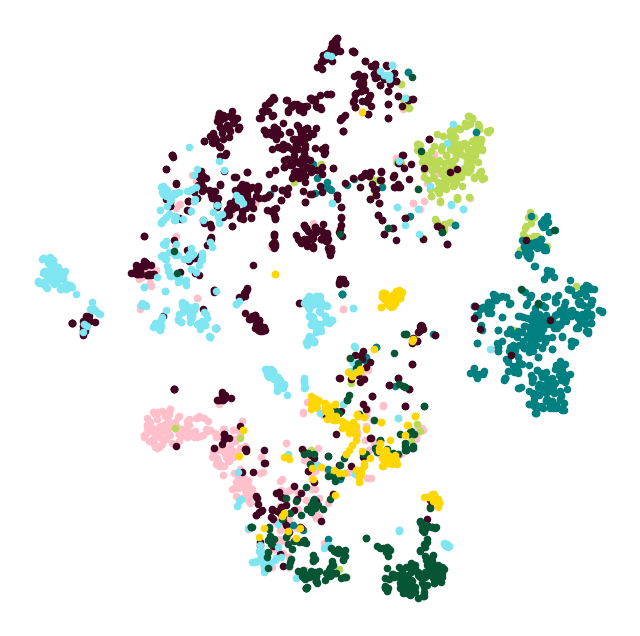

In [16]:
#%%
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)